# What target should we use:
* We could improve this notebook to solve the question with distributions !.
* Imagine that we can perfectly predict a certain target.
* Can we come out with a trading strategy based on this model?
* How often and accurate do we need to be able to do this?
* Lets not think on fees for now - ugly.
* This is the quantity that we want to predict: (S1.pct_change()+1).shift(-2) = S1.pct_change().shift(-2)+1
* Its equivalent to predicting S1.pct_change().shift(-2)

In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [2]:
import pandas as pd
import random
import numpy as np
import datetime as datetime

In [3]:
minutesPerDay = 390

def simulateMultipleStrategies(S1, S2, precision = 80, recall=10, numExperiments=100, sizeExperiment=1*minutesPerDay):
    """ Comment
    """

    S = pd.concat([S1,S2], axis=1).dropna()
    S.columns=['S1', 'S2']
    lenS=len(S)
    experimentStarts = random.choices(range(lenS-sizeExperiment), k=numExperiments)

    endPriceS1=[]
    endPriceS2= []
    endPriceStragegy = []
    
    for es in experimentStarts:
        T1=S[es:es+sizeExperiment]['S1']
        T2=S[es:es+sizeExperiment]['S2']
        end1, end2, endStrategy = simulateStrategyWithNoisyPredictor(T1, T2, precision, recall)
        endPriceS1.append(end1)
        endPriceS2.append(end2)
        endPriceStragegy.append(endStrategy)
    return endPriceS1, endPriceS2, endPriceStragegy


def simulateStrategyWithNoisyPredictor(S1, S2, precision, recall):
    """ Comment
    """
    lenS = len(S1)
    I1 = (1+S1.pct_change()).fillna(1).values
    I2 = (1+S2.pct_change()).fillna(1).values
    Imin = [min(I1[i], I2[i]) for i in range(lenS)]
    Imax = [max(I1[i], I2[i]) for i in range(lenS)]
    
    numPredictions = (lenS*recall)//100
    numCorrectPredictions = (numPredictions*precision)//100
    predictionIndexes = random.sample(range(lenS), numPredictions)
    correctPredictionIndexes = predictionIndexes[:numCorrectPredictions]
    wrongPredictionIndexes = predictionIndexes[numCorrectPredictions:]
    
    Strategy = [I1[i] if random.choice([True,False]) else I2[i] for i in range(lenS)]
    for goodIndex in correctPredictionIndexes: Strategy[goodIndex]=Imax[goodIndex]
    for badIndex in wrongPredictionIndexes: Strategy[badIndex]=Imin[badIndex]
    return np.prod(I1), np.prod(I2), np.prod(Strategy)
    

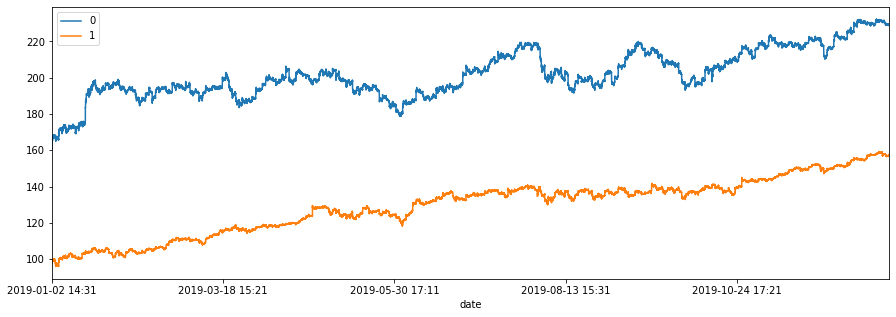

In [4]:
df = pd.read_csv('data/quantopian/minuteIntraday/GS.csv').drop(columns=['volume']).set_index('date')
S1 = df.mean(axis=1)
df = pd.read_csv('data/quantopian/minuteIntraday/MSFT.csv').drop(columns=['volume']).set_index('date')
S2 = df.mean(axis=1)
pd.concat([S1,S2], axis=1).plot(figsize=(15,5))

In [23]:
endStock1, endStock2, endStrategy = simulateMultipleStrategies(S1, S2, precision = 70, recall=10, numExperiments=50, sizeExperiment=20*390)


In [24]:
dr=pd.DataFrame({'endStock1':endStock1, 'endStock2':endStock2, 'endStrategy':endStrategy})

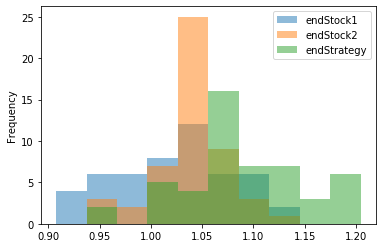

In [26]:
dr.plot.hist(bins=10, alpha=0.5)

In [27]:
dr['bestStock']=dr[['endStock1', 'endStock2']].max(axis=1)

In [28]:
dr['difference']=dr.endStrategy-dr.bestStock

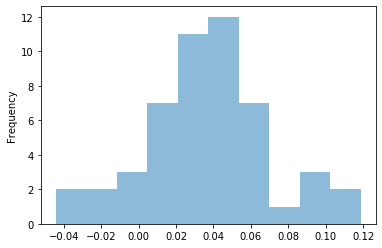

In [30]:
dr.difference.plot.hist(bins=10, alpha=0.5)

In [ ]:
ds = pd.concat([S1, S2], axis=1)
ds = ds.dropna(how='any')
ds.columns = ['IBM', 'IOH']
ds.plot(figsize=(15,5))

In [ ]:
ds = ds[-100000:].copy()
ds['increaseIBM'] = (1+ds.IBM.pct_change()).fillna(1)
ds['increaseIOH'] = (1+ds.IOH.pct_change()).fillna(1)
ds['increaseGOD'] = ds.apply(lambda x: max(x.increaseIBM, x.increaseIOH), axis=1)
ds['positionGOD'] = ds.apply(lambda x: 'IBM' if x.increaseIBM>x.increaseIOH else 'IOH', axis=1)
ds['increaseDUM'] = ds.apply(lambda x: min(x.increaseIBM, x.increaseIOH), axis=1)
ds['positionDUM'] = ds.apply(lambda x: 'IBM' if x.increaseIBM<x.increaseIOH else 'IOH', axis=1)
ds['positionMON'] = [random.choice(['IBM','IOH']) for _ in range(len(ds))]
ds['increaseMON'] = ds.apply(lambda x: x['increase'+x.positionMON], axis=1)
# sanity check:
#ds.increaseIBM.prod()

In [ ]:
100*(5000/100000)

In [ ]:
moves = [None for _ in range(len(ds))]
indexes = [i for i in range(len(ds))]
goodMoves = np.random.choice(indexes, size = 4000, replace=False, p=None)
badMoves = np.random.choice(indexes, size = 1000, replace=False, p=None)
for gi in goodMoves: moves[gi]='positionGOD'
for bi in badMoves: moves[bi]='positionDUM'

ds['positionSTR'] = moves
ds['positionSTR'] = ds.apply(lambda x: x[x.positionSTR] if x.positionSTR is not None else None, axis=1)
   
positions = ds.positionSTR.values
positions[0]='IBM'

for i in range(1, len(positions)):
    positions[i]=positions[i-1] if positions[i]==None else positions[i]

ds['positionSTR']=positions
ds['increaseSTR']= ds.apply(lambda x: x['increase'+x.positionSTR], axis=1)

In [ ]:
print(ds.increaseIBM.product())
print(ds.increaseIOH.product())
print(ds.increaseGOD.product())
print(ds.increaseMON.product())
print(ds.increaseDUM.product())

In [ ]:
ds[[col for col in ds.columns if 'increase' in col ]].drop(columns=['increaseGOD', 'increaseDUM']).cumprod().plot(figsize=(15, 6))

In [ ]:
# number of movements we have to make?
positions = ds.positionSTR.values
counter = 0
for i in range(1, len(positions)):
    counter+=0 if positions[i]==positions[i-1] else 1
print(counter)

In [ ]:
ds.shape

In [ ]:
#259 days 4800 transactions

In [ ]:
2500/259